# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator Understanding

The 2-pager description of universal statistical simulator can be found here.

## Part II - General Algorithm for Quantum Galton Box

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [107]:
SHOTS = 4096

In [108]:
get_device = lambda n: qml.device("default.qubit", wires=2*n+2, shots=SHOTS)

In [109]:
def calculate_wire_tuples(n, level) -> list:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i+1) for i in range(middle - level, middle + level)]

In [110]:
def run_circuit(circuit_generator, n, coin_function, reverse=False):
    my_circuit = circuit_generator(n, coin=coin_function)
    samples = my_circuit()
    bitstrings = ["".join(str(bit) for bit in sample) for sample in samples]
    freqs = Counter(bitstrings)
    freqs = dict(sorted(freqs.items(), reverse=reverse))
    return freqs

In [111]:
def plot_freqs(freqs, title, reference_values=None):
    """Plots the frequencies of bitstrings as a histogram, with optional reference line."""
    plt.bar(freqs.keys(), freqs.values(), label="Quantum Galton Box")
    if reference_values is not None:
        plt.plot(list(freqs.keys()), reference_values, color="red", marker="o", linestyle="-", label="Reference")
    plt.xlabel("Bitstring")
    plt.ylabel("Frequency")
    plt.title(title)
    if reference_values is not None:
        plt.legend()
    plt.show()

In [112]:
def create_qgb_circuit(n, coin):
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    dev = get_device(n)
        
    def qpegs(wire_tuples):
        for i, wires in enumerate(wire_tuples):
            qml.CSWAP(wires=[0, wires[0], wires[1]])
            if i < len(wire_tuples) - 1:
                qml.CNOT(wires=[wires[1], 0])
    

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n+1)
        for level in range(1, n+1):
            coin(n, level)
            qpegs(wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qml.measure(wires=0, reset=True)
        return qml.sample(wires=range(1, 2*n+2, 2))
    
    return qgb_circuit


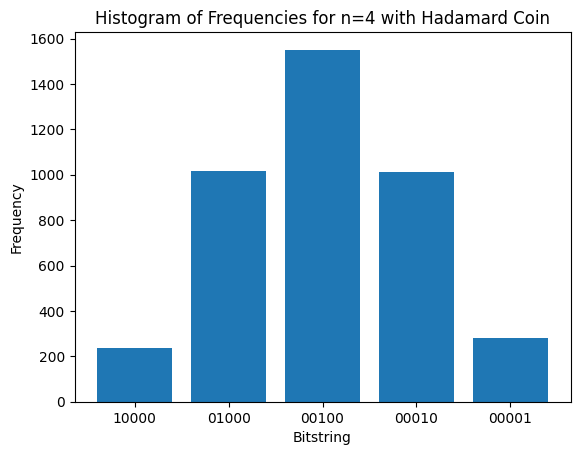

In [113]:
n = 4
coin_function = lambda n, level: qml.Hadamard(wires=0)
freqs = run_circuit(create_qgb_circuit, n, coin_function, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Hadamard Coin")

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

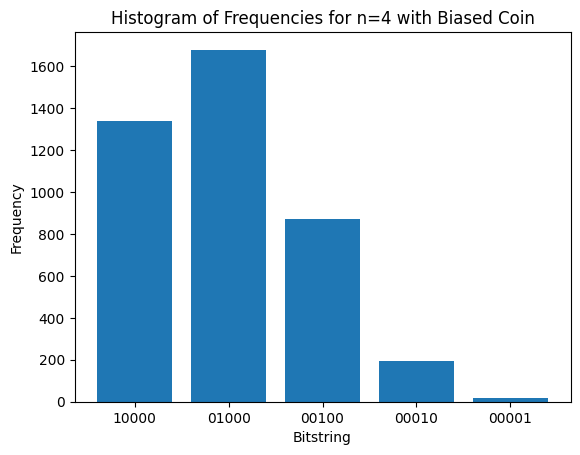

In [114]:
n = 4
coin_function = lambda n, level: qml.RY(2*np.pi/3, 0)
freqs = run_circuit(create_qgb_circuit, n, coin_function, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Biased Coin")

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [115]:
def exponential_coin(n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * np.acos(np.sqrt(1 / np.e)) 
    if level == 1:
        qml.RY(theta, wires=0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qml.CNOT(wires=[i, 0])
        qml.CRY(theta, wires=[middle + level - 1, 0])

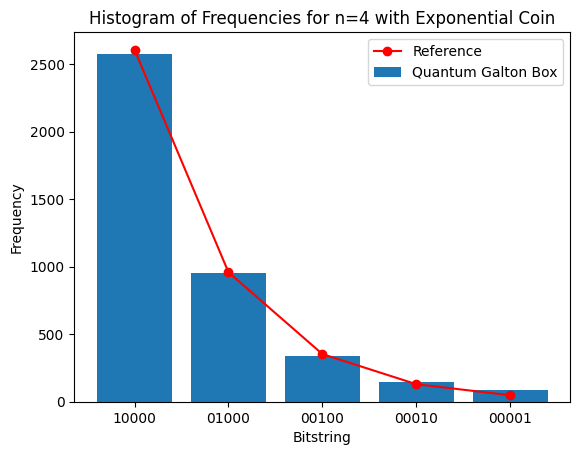

In [117]:
n = 4

x = np.arange(0, n+1)
lambda_rate = 1
reference_freqs = np.exp(-lambda_rate * x)
reference_freqs /= reference_freqs.sum()
reference_freqs *= SHOTS

freqs = run_circuit(create_qgb_circuit, n, exponential_coin, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Exponential Coin", reference_values=reference_freqs)

In [12]:
#circuit = create_qgb_circuit(3, coin=exponential_coin)
#qml.draw_mpl(circuit, show_all_wires=True)()

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [13]:
# def calculate_wire_tuples(n, level) -> list:
#     if level < 1 or level > n:
#         raise ValueError("Level must be between 1 and n (inclusive).")
#     middle = n + 1
#     return [(i, i+1) for i in range(middle - level, middle + level)]


# def create_qgb_hrw_circuit(n, coin):
#     """Creates a quantum circuit for the Hadamard Random Walk on Quantum Galton Board (QGB) with n levels."""

#     dev = get_device(n)
        
#     def qpegs(wire_tuples):
#         control_value = 1
#         for wires in wire_tuples:
#             qml.ctrl(qml.SWAP, control=0, control_values=control_value)(wires=wires)
#             control_value ^= 1
    

#     @qml.qnode(dev)
#     def qgb_circuit():
#         qml.X(wires=n+1)
#         coin(1)
#         for level in range(1, n+1):
#             qpegs(wire_tuples=calculate_wire_tuples(n, level))
#         return qml.sample(wires=range(1, 2*n+2, 2))
    
#     return qgb_circuit

In [118]:
def create_hrw_qgb_circuit(n, coin):
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    dev = get_device(n)
        
    def qpegs(wire_tuples):
        control_value = 1
        for i, wires in enumerate(wire_tuples):
            qml.ctrl(qml.SWAP, control=0, control_values=control_value)(wires=wires)
            control_value ^= 1
            #if i < len(wire_tuples) - 1:
            #    qml.CNOT(wires=[wires[1], 0])
    

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n+1)
        for level in range(1, n+1):
            coin(n, 1)
            qpegs(wire_tuples=calculate_wire_tuples(n, level))
            #if level < n:
            #    qml.measure(wires=0, reset=True)
        return qml.probs(wires=range(1, 2*n+2, 2))
    
    return qgb_circuit

In [119]:
def hadamard_coin(n, level):
    """Applies a Hadamard coin rotation based on the level."""
    qml.Hadamard(wires=0)

In [135]:
def reference_hadamard_distribution(num_steps):
    hadamard = lambda: np.array([[1, 1], [1, -1]]) / np.sqrt(2)

    position_range = 2 * num_steps + 1
    mid = position_range // 2
    state = np.zeros((2, position_range), dtype=complex)
    state[:, mid] = np.array([1, 0])
    H = hadamard()
    for _ in range(num_steps):
        coin_transformed = np.zeros_like(state, dtype=complex)
        for pos in range(position_range):
            coin_state = state[:, pos]
            coin_transformed[:, pos] = H @ coin_state
        new_state = np.zeros_like(state, dtype=complex)
        for pos in range(position_range):
            for coin in [0, 1]:
                shift = -1 if coin == 0 else 1
                new_pos = pos + shift
                if 0 <= new_pos < position_range:
                    new_state[coin, new_pos] += coin_transformed[coin, pos]
        state = new_state
    total_prob = np.sum(np.abs(state)**2)
    probabilities = np.sum(np.abs(state)**2, axis=0) / total_prob
    positions = np.arange(-num_steps, num_steps + 1)
    return positions, probabilities

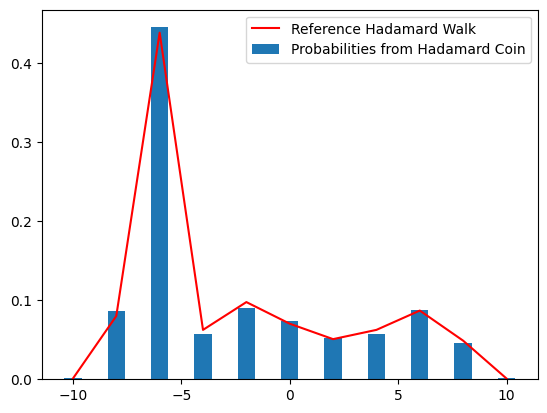

In [139]:
n = 10
probs = [float(p) for p in create_hrw_qgb_circuit(n, hadamard_coin)() if p > 0]
_, reference_probs = reference_hadamard_distribution(n)
plt.bar(list(range(-n, n+1, 2)), probs, label="Probabilities from Hadamard Coin")
plt.plot(list(range(-n, n+1, 2)), reference_probs[::2], color='red', label="Reference Hadamard Walk")
plt.legend()
plt.show()

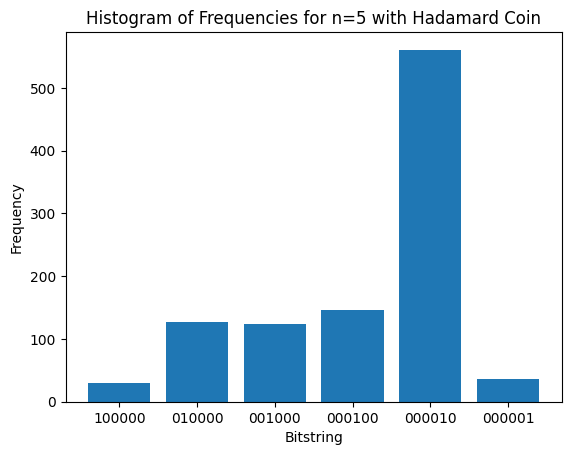

{'100000': 30, '010000': 127, '001000': 124, '000100': 146, '000010': 561, '000001': 36}


In [106]:
n = 5
freqs = run_circuit(create_hrw_qgb_circuit, n, hadamard_coin, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Hadamard Coin")
print(freqs)